In [1]:
import pandas as pd
import cv2
import numpy as np
import scipy
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%matplotlib inline

source = 0
deg_to_rad = np.pi/180
spat_freq = 0.08

In [2]:
df = pd.read_csv("cell_metrics_VISp.csv")

In [3]:
id_cols = [
    "experiment_container_id", "cell_specimen_id"
]

sg_cols = [
    "pref_ori_sg", "pref_sf_sg", "pref_phase_sg"
]

dg_cols = [
    "pref_dir_dg", "pref_tf_dg"
]

In [4]:
df = df[df["failed_experiment_container"]=="f"]
len(df)

63251

### Video Capturing

In [30]:
window_webcam = "Webcam"
cv2.namedWindow(window_webcam, cv2.WINDOW_NORMAL)

cam = cv2.VideoCapture(source)

In [31]:
dts = []
video = []
T = 10

while sum(dts) < T:
    start = time.time()
    
    _ret, frame = cam.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.resize(frame_gray, dsize=None, fx=.5, fy=.5)
    frame_gray = cv2.flip(frame_gray, 1)
    # frame_gray_mean = frame_gray.mean()
    # frame_gray = (frame_gray - frame_gray_mean) / frame_gray_mean

    cv2.imshow(window_webcam, frame_gray)
    
    # frame_gray_norm = (frame_gray - frame_gray.min()) / (frame_gray.max() - frame_gray.min())
    
    video.append(frame_gray)
    
    key = cv2.waitKey(5)
    if key == 27: # exit on ESC
        break
        
    end = time.time()
    dt = end-start
    dts.append(dt)

In [32]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [ ]:
video = (video - video.min()) / (video.max() - video.min())

In [33]:
video = np.moveaxis(np.array(video, dtype=np.float16), 0, -1)

frames_per_s = np.ceil(video.shape[-1] / sum(dts))
print(f"Video shape: {video.shape}")
print(f"FPS: {frames_per_s}")

Video shape: (360, 640, 281)
FPS: 29.0


### Sample Dynamic Filters

In [5]:
df_dg = df[id_cols+dg_cols].dropna()

len(df_dg)

29635

In [6]:
df_dg

,experiment_container_id,cell_specimen_id,pref_dir_dg,pref_tf_dg
1,511498742,517397340,0.0,1.0
2,511498742,517397343,180.0,2.0
5,511498742,517397357,135.0,1.0
7,511498742,517397365,180.0,1.0
9,511498742,517397373,225.0,1.0
...,...,...,...,...
63241,712178509,738949092,0.0,2.0
63243,712178509,738949156,180.0,1.0
63245,712178509,738949207,0.0,2.0
63248,712178509,738949318,45.0,1.0


In [7]:
frames_per_s = 60

In [8]:
n_filters = 10

df_dg_sample = df_dg.sample(n_filters)

gs = [
    np.moveaxis(np.array([
        cv2.getGaborKernel(
            ksize=(81,81),
            sigma=40,
            theta=r['pref_dir_dg']*deg_to_rad,
            lambd=1/spat_freq,
            gamma=1,
            psi=i*2*np.pi,
        )
        for i in np.linspace(0, 1, int(frames_per_s/r['pref_tf_dg']))
    ], dtype=np.float16), 0, -1)
    for _, r in df_dg_sample.iterrows()
]

oris = [r['pref_dir_dg'] for _, r in df_dg_sample.iterrows()]
t_freqs = [r['pref_tf_dg'] for _, r in df_dg_sample.iterrows()]

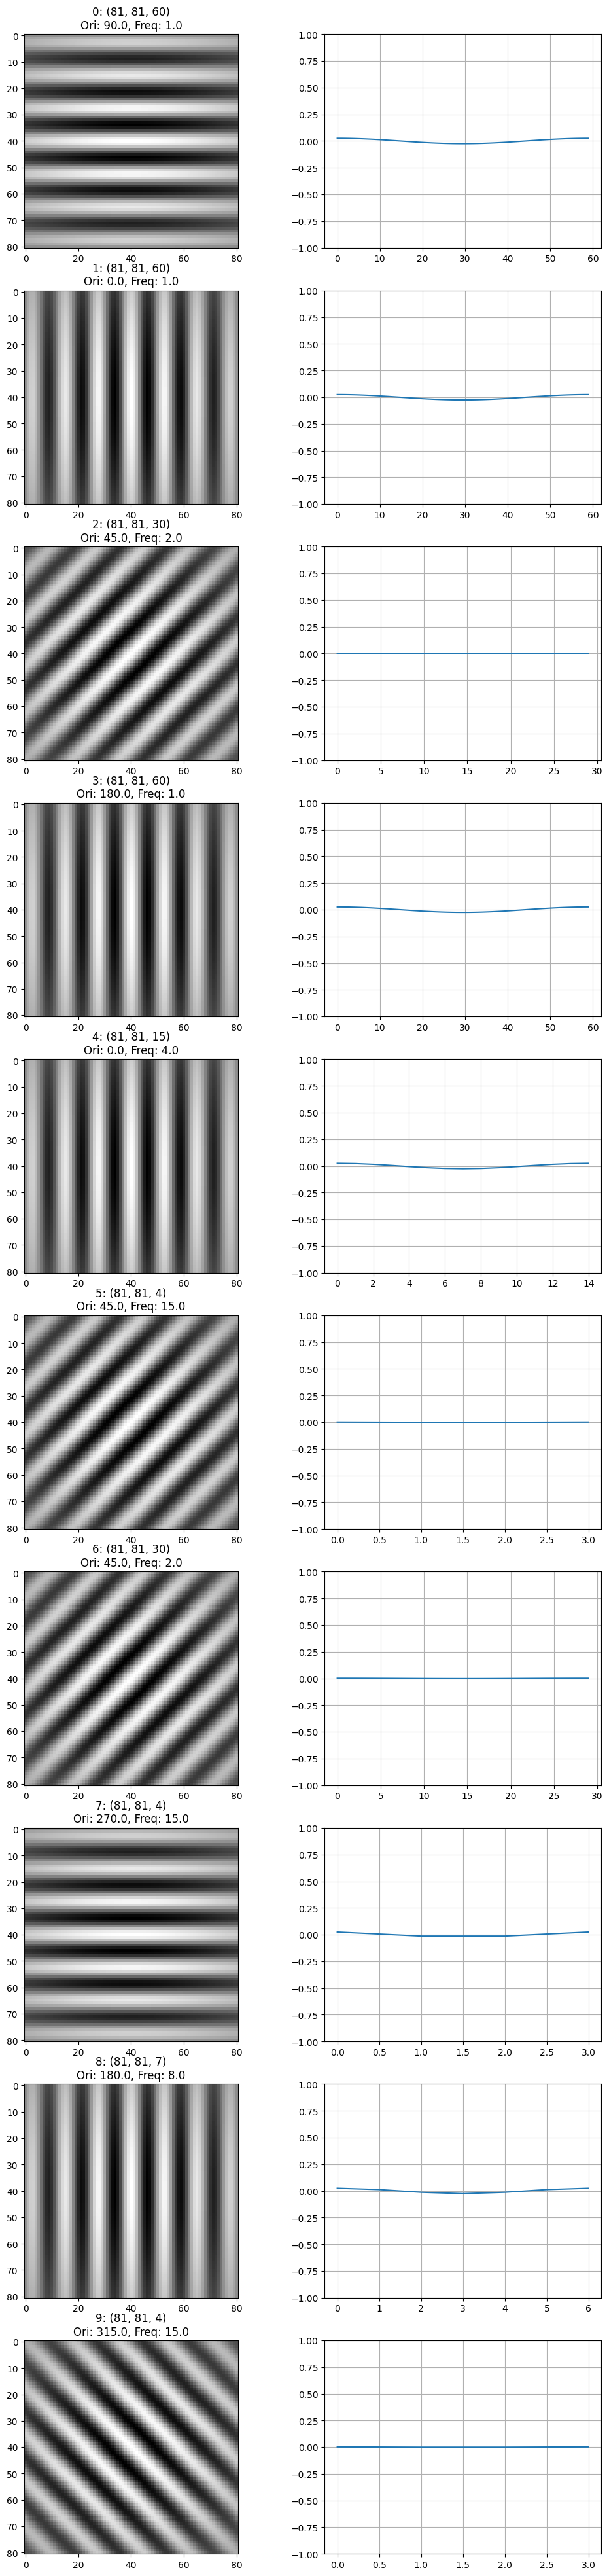

In [9]:
fig, axs = plt.subplots(len(gs), 2, figsize=(12, 5*len(gs)))

for idx, g_t in enumerate(gs):
    axs[idx, 0].imshow(g_t[:,:,0], cmap='gray')
    axs[idx, 0].set_title(f"{idx}: {g_t.shape}\nOri: {oris[idx]}, Freq: {t_freqs[idx]}")

    axs[idx, 1].plot(range(g_t.shape[-1]), np.mean(g_t, axis=(0,1)))
    axs[idx, 1].set_ylim([-1,1])
    axs[idx, 1].grid()
    
plt.show()

In [10]:
sample = 2
gs_sample = gs[sample]
gs_sample.shape

(81, 81, 30)

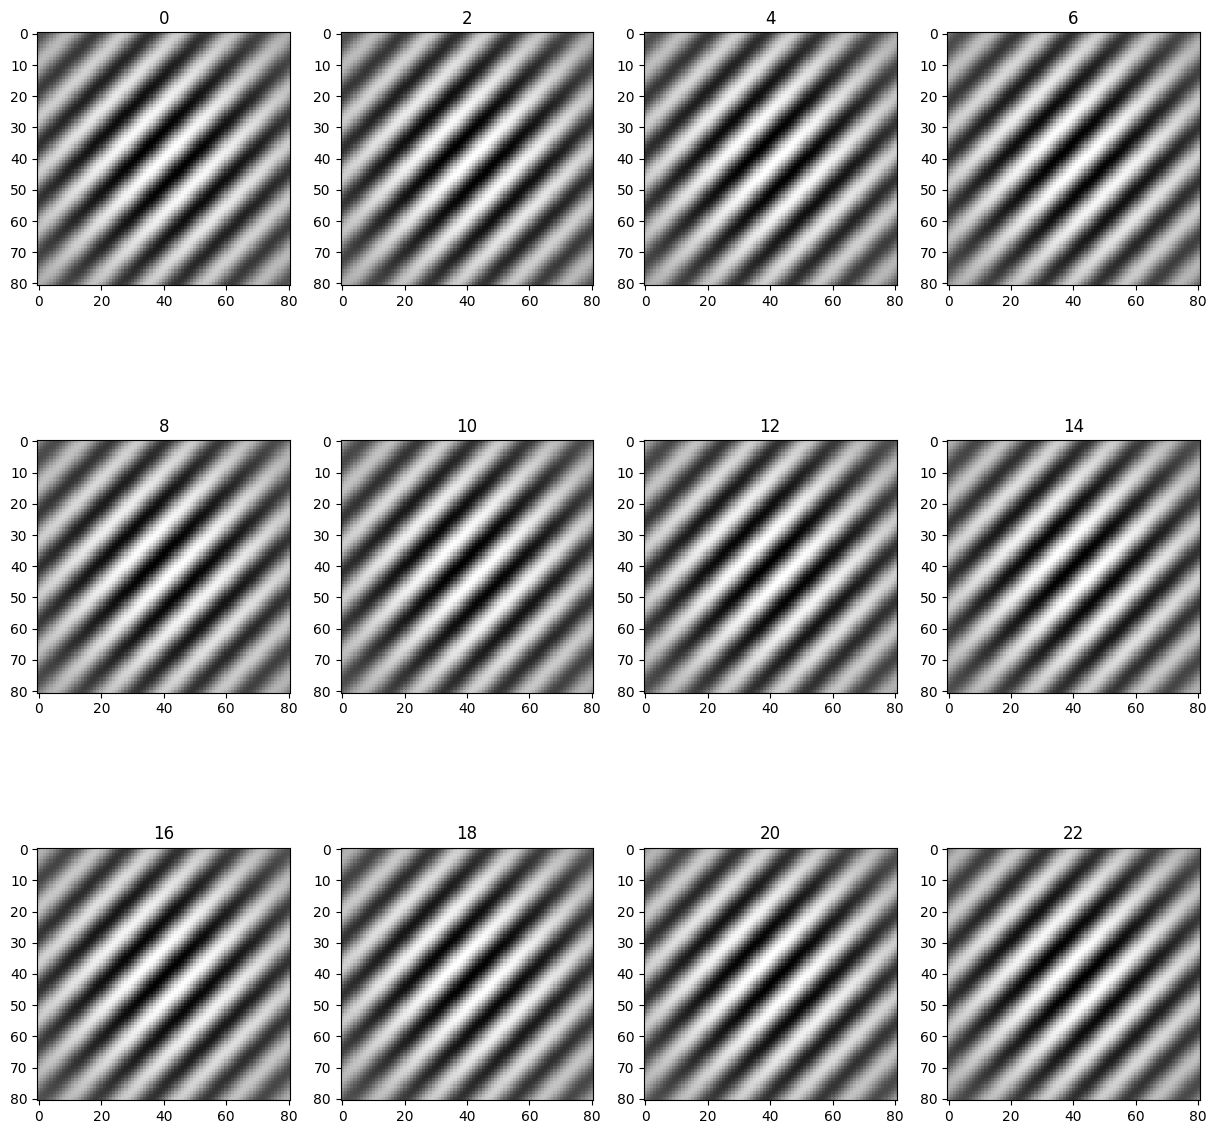

In [11]:
fig, axs = plt.subplots(3, 4, figsize=(15, 15))

for ax, t in zip(axs.flatten(), np.arange(0, gs_sample.shape[-1], int(np.floor(gs_sample.shape[-1]/len(axs.flatten()))))):
    # Make data.
    ax.imshow(gs_sample[:,:,t], cmap='gray')

    ax.set_title(t)

plt.savefig("img.jpg")
plt.show()

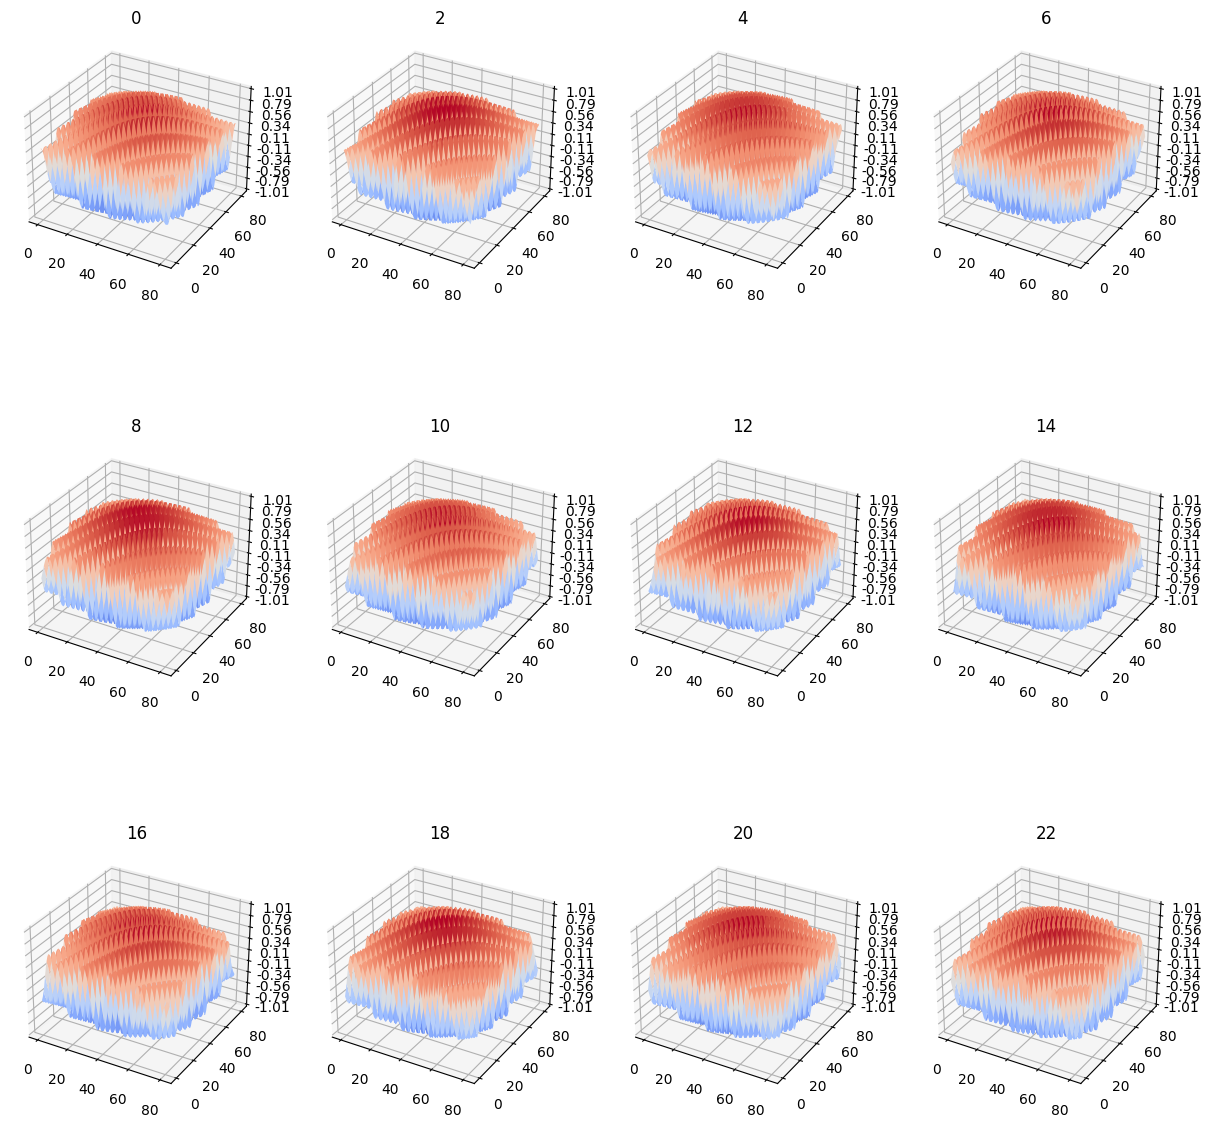

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(15, 15),subplot_kw={"projection": "3d"})

for ax, t in zip(axs.flatten(), np.arange(0, gs_sample.shape[-1], int(np.floor(gs_sample.shape[-1]/len(axs.flatten()))))):
    # Make data.
    l = gs_sample.shape[0]
    
    X = np.linspace(0, l, l)
    Y = np.flip(np.linspace(0, l, l))
    X, Y = np.meshgrid(X, Y)

    Z = gs_sample[..., t]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)

    ax.set_title(t)
    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

plt.savefig("img_3d.jpg")
plt.show()

In [13]:
video_conv_dict = {}

In [14]:
gs_repeated = [np.repeat(g_t, 10, axis=-1) for g_t in gs]
video_demo = np.concatenate(gs_repeated, axis=-1)
# video_demo = (video_demo - video_demo.min()) / (video_demo.max() - video_demo.min())

In [15]:
video = video_demo
for g_idx, g_t in enumerate(gs):
    print(f"Kernel {g_idx}")
    print(video.shape, video.dtype, flush=True)
    print(g_t.shape, g_t.dtype, flush=True)
    print("ready!", flush=True)
    video_conv = scipy.signal.fftconvolve(
        video,
        g_t,
        mode='same',
    )

    print("convolution done!", flush=True)
    print("ready to normalize!", flush=True)

    video_conv = 255*(video_conv - video_conv.min())/(video_conv.max() - video_conv.min())
    video_conv_dict[g_idx] = video_conv
    
    print()

Kernel 0
(81, 81, 2740) float16
(81, 81, 60) float16
ready!
convolution done!
ready to normalize!

Kernel 1
(81, 81, 2740) float16
(81, 81, 60) float16
ready!
convolution done!
ready to normalize!

Kernel 2
(81, 81, 2740) float16
(81, 81, 30) float16
ready!
convolution done!
ready to normalize!

Kernel 3
(81, 81, 2740) float16
(81, 81, 60) float16
ready!
convolution done!
ready to normalize!

Kernel 4
(81, 81, 2740) float16
(81, 81, 15) float16
ready!
convolution done!
ready to normalize!

Kernel 5
(81, 81, 2740) float16
(81, 81, 4) float16
ready!
convolution done!
ready to normalize!

Kernel 6
(81, 81, 2740) float16
(81, 81, 30) float16
ready!
convolution done!
ready to normalize!

Kernel 7
(81, 81, 2740) float16
(81, 81, 4) float16
ready!
convolution done!
ready to normalize!

Kernel 8
(81, 81, 2740) float16
(81, 81, 7) float16
ready!
convolution done!
ready to normalize!

Kernel 9
(81, 81, 2740) float16
(81, 81, 4) float16
ready!
convolution done!
ready to normalize!



In [19]:
kernel_n = 1

window_filter = f"Kernel {kernel_n}"
cv2.namedWindow(window_filter, cv2.WINDOW_NORMAL)

In [20]:
video_conv = video_conv_dict[kernel_n]

for idx in range(video_conv.shape[-1]):
    cv2.imshow(window_filter, video_conv[:,:,idx])
    
    key = cv2.waitKey(5)
    if key == 27: # exit on ESC
        break
        
    time.sleep(1/frames_per_s)
    
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 

In [16]:
gs_repeated[2].shape

(81, 81, 300)

In [17]:
video_conv = video_conv_dict[2]

In [18]:
idx = 0
for i, gsr in enumerate(gs_repeated):
    video_conv_tmp = video_conv[..., idx:idx+gsr.shape[-1]]
    print(f"{i} ({oris[i]}, {t_freqs[i]}) mean value: {video_conv_tmp.mean()}")
    print()
    idx += gsr.shape[-1]

0 (90.0, 1.0) mean value: 123.90665435791016

1 (0.0, 1.0) mean value: 123.9072494506836

2 (45.0, 2.0) mean value: 123.90479278564453

3 (180.0, 1.0) mean value: 123.90718841552734

4 (0.0, 4.0) mean value: 123.90809631347656

5 (45.0, 15.0) mean value: 123.90644836425781

6 (45.0, 2.0) mean value: 123.9054183959961

7 (270.0, 15.0) mean value: 123.91436004638672

8 (180.0, 8.0) mean value: 123.90696716308594

9 (315.0, 15.0) mean value: 123.90614318847656



# 